# Task 1

## Introduction
We will use the South German Credit dataset to determine whether someone should be given credit. The target variable is credit_risk, and individuals are assigned either a 0 (good) or 1 (bad). The cost matrix that comes with the orginial dataset reveals that it " is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1)." The bank therefore probably incurs a greater loss by giving money to a bad debtor than by withholding money from a good debtor. This must be taken into account when evaluating the model, as we will want fewer false negatives than false positives.

It is a supervised learning task since we are given the labels (i.e. credit_risk). It is also a binary classification task, since we have two class labels. Since there is no continuous flow of data and the data is quite small, batch learning will be fine for this project.

#### Importing Packages

In [1218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier


from statistics import mean, stdev
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from sklearn.linear_model import RidgeClassifier
from imblearn.combine import SMOTEENN


## Preliminary Exploration

In [1219]:
credit = pd.read_csv("credit")

credit.head(10)

,credit_risk,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
0,0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,0,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,0,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,1,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201
5,0,A14,36,A32,A46,9055,A65,A73,2,A93,A101,4,A124,35,A143,A153,1,A172,2,A192,A201
6,0,A14,24,A32,A42,2835,A63,A75,3,A93,A101,4,A122,53,A143,A152,1,A173,1,A191,A201
7,0,A12,36,A32,A41,6948,A61,A73,2,A93,A101,2,A123,35,A143,A151,1,A174,1,A192,A201
8,0,A14,12,A32,A43,3059,A64,A74,2,A91,A101,4,A121,61,A143,A152,1,A172,1,A191,A201
9,1,A12,30,A34,A40,5234,A61,A71,4,A94,A101,2,A123,28,A143,A152,2,A174,1,A191,A201


The categorical variables take an Axxx format. One-hot encoding of these variables is therefore necessary.

The numerical columns have different scales and will therefore need to be scaled.

The class contains values of 0 and 1, where 0 is 'good' (negative class) and 1 is 'bad' (positive class).

In [1220]:
credit.shape

(1000, 21)

There are 1,000 rows, 20 attributes, and 1 target variable.

0    700
1    300
Name: credit_risk, dtype: int64

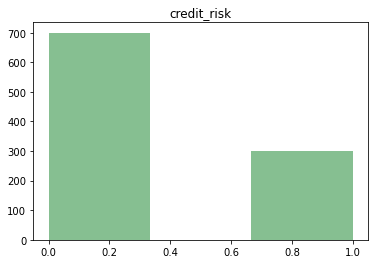

In [1221]:
credit.hist(column="credit_risk", grid=False, color='#86bf91', bins=3)

credit["credit_risk"].value_counts()

The class distribution is 70% negative and 30% positive.

In [1222]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   credit_risk              1000 non-null   int64 
 1   status                   1000 non-null   object
 2   duration                 1000 non-null   int64 
 3   credit_history           1000 non-null   object
 4   purpose                  1000 non-null   object
 5   amount                   1000 non-null   int64 
 6   savings                  1000 non-null   object
 7   employment_duration      1000 non-null   object
 8   installment_rate         1000 non-null   int64 
 9   personal_status_sex      1000 non-null   object
 10  other_debtors            1000 non-null   object
 11  present_residence        1000 non-null   int64 
 12  property                 1000 non-null   object
 13  age                      1000 non-null   int64 
 14  other_installment_plans  1000 non-null   

There are no duplicate values, nor missing values.

Although the dataset is imbalanced and contains more 'good' than 'bad', with 300 instances of 'bad', there is enough to perform a machine learning model. However, we will have to account for this imbalance.

Ostensibly, there are are seven numeric variables, but some of these are actually categorical variables in discrete numeric form.

### X and y 

In [1223]:
# stratified split
y = credit["credit_risk"]
X = credit.drop("credit_risk", axis=1)

Let's look at the continuous attributes:

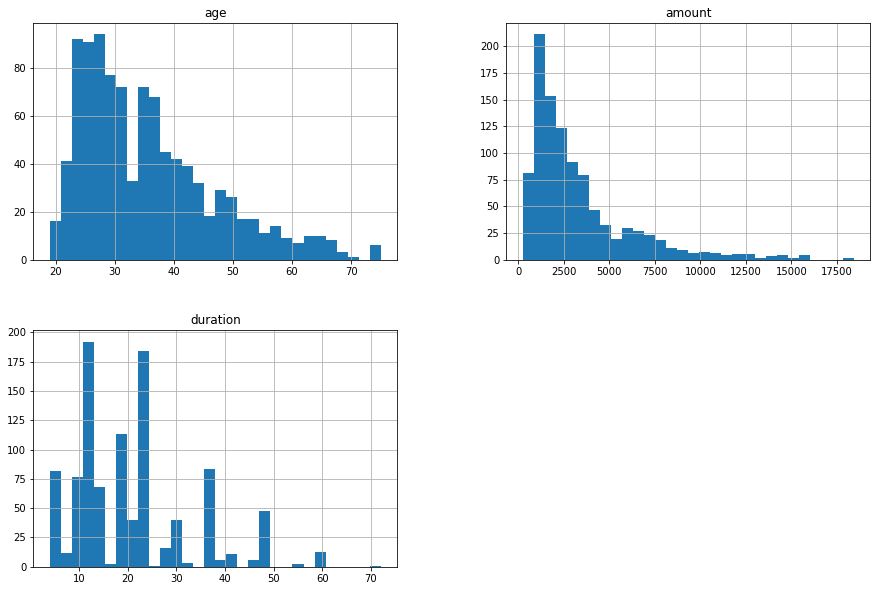

In [1224]:
continuous_attributes = ['age', 'amount','duration']
X.hist(continuous_attributes, bins=30, figsize=(15,10))
plt.show()

We may need to transform some of the continuous variables since they are somewhat tail-heavy. 

### Attribute Selection

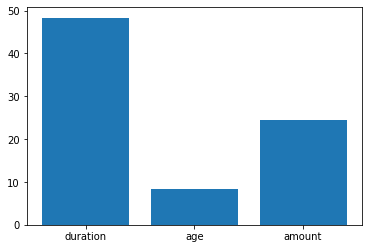

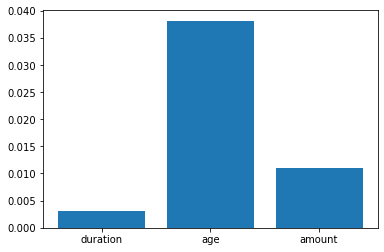

In [1225]:
# selecting numeric attributes
num_cols = X[["duration", "age", "amount"]]

# standardizing
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(num_cols)

score_functions = [f_regression, mutual_info_regression]
for i in score_functions:
    fs_top = SelectKBest(score_func=i, k="all")
    fs_top.fit_transform(X_num_scaled, y)
    
    # creating dictionary with att names and respective scores
    scores = {}
    for n, s in zip(["duration", "age", "amount"], fs_top.scores_):
        scores[n] = s
        
    plt.bar(range(len(scores)), list(scores.values()), align='center')
    plt.xticks(range(len(scores)), list(scores.keys())) 
    plt.show()


Let's try with the ExtraTreesClassifier:

In [1226]:
continuous_features = ["age", "duration", "amount"]
# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X[continuous_features], y)
print(continuous_features)
print(model.feature_importances_)

['age', 'duration', 'amount']
[0.30000833 0.17395892 0.52603274]


Based on these three scores, 'amount is clearly the most important, followed by 'duration' and then 'age'. We will try a model that only uses 'amount' as a continuous attribute.

For the categorical attributes, we will use chi-squared.

status: 123.333665
credit_history: 24.103752
purpose: 0.005246
savings: 72.269985
employment_duration: 8.232742
personal_status_sex: 2.315724
other_debtors: 0.993432
property: 16.501718
other_installment_plans: 3.582800
housing: 0.113230
job: 0.240196
telephone: 0.792551
foreign_worker: 6.487773


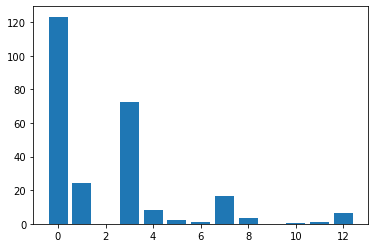

In [1227]:
# selecting categorical attributes
cat_cols = list(X.select_dtypes(include=['object']))

# encoding categorical variables
encoder_pipe = ColumnTransformer([
    ("cat", OrdinalEncoder(), cat_cols)
])
X_encoded = encoder_pipe.fit_transform(X)

# chi-squared
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_encoded, y)

# ranking features
for i, f in zip(range(len(fs.scores_)), cat_cols):
    print('%s: %f' % (f, fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

Based on chi-squared, the most important categorical attributes appear to be 'status', 'credit_history', 'savings', 'employment_duration', 'property', 'other_installments' and 'foreign_worker'.

status: 0.046572
credit_history: 0.049171
purpose: 0.025391
savings: 0.036948
employment_duration: 0.000000
personal_status_sex: 0.000000
other_debtors: 0.000000
property: 0.019049
other_installment_plans: 0.019440
housing: 0.036695
job: 0.000000
telephone: 0.009730
foreign_worker: 0.002468


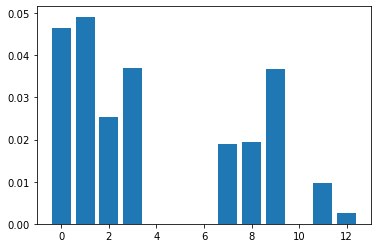

status: 140.092281
credit_history: 55.123045
purpose: 0.002289
savings: 33.013573
employment_duration: 13.612739
personal_status_sex: 7.821743
other_debtors: 0.630992
property: 20.718883
other_installment_plans: 12.188660
housing: 0.372463
job: 1.070584
telephone: 1.328891
foreign_worker: 6.769174


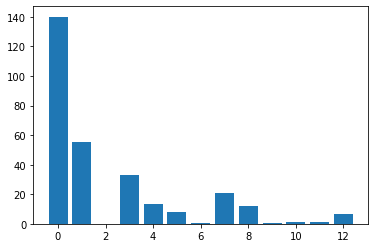

In [1228]:
score_functions = [mutual_info_classif, f_classif]

for fun in score_functions:
    
    fs = SelectKBest(score_func=fun, k='all')
    fs.fit(X_encoded, y)

    # ranking features
    for i, f in zip(range(len(fs.scores_)), cat_cols):
        print('%s: %f' % (f, fs.scores_[i]))

    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()

The ANOVA F-value (second chart) appears very similar to the chi-squared results, while mutual information gives slightly different results. Overall, sticking with the chi-squared attributes seems about right:

In [1229]:
X = X[['status','credit_history','purpose','savings','employment_duration',
 'personal_status_sex','other_debtors','property','other_installment_plans','housing','foreign_worker',
 'age', 'amount', 'duration']]

### Encoding & Scaling

Of our selected attributes, two are ordinal: 'employment_duration' and 'property'. These will be ordinal encoded while the rest will be one hot encoded. The highest scoring continuous variables, 'amount' and 'duration' will also be min max scaled.

In [1230]:
# selecting features
ord_atts = ["employment_duration", "property"]
nom_atts = ['status','credit_history','purpose','savings', 'personal_status_sex','other_debtors','other_installment_plans','housing','foreign_worker']
cont_atts = ["age", "amount", "duration"]

# encoding with ColumnTransformer
ct = ColumnTransformer([
    ("scaler", MinMaxScaler(), cont_atts),
    ("1hot", OneHotEncoder(), nom_atts),
    ("ordinal", OrdinalEncoder(), ord_atts)], remainder="passthrough")
X_transformed = ct.fit_transform(X)

## Model Evaluation

### Baseline Model
We need an f2 score first:

In [1231]:
# calculate f2 score
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

We next need a function will evaluate a given model and return the F2 scores:

In [1232]:
def evaluate_model(X, y, model):
    # cross validation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    # evaluation metric
    metric = make_scorer(f2_score)
    
    # evaluating the model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# code copied from https://machinelearningmastery.com/imbalanced-classification-of-good-and-bad-credit/

Evaluating the baseline model:

In [1233]:
# defining dummy model
model = DummyClassifier(strategy='constant', constant=1)

# evaluating the model
scores = evaluate_model(X, y, model)

# summarize performance
print('Mean F2: %.3f (%.3f)' % (mean(scores), stdev(scores)))

Mean F2: 0.682 (0.000)


So we need to do better than an F2-score of 0.68.

### Evaluating Different Models

In [1234]:
def define_models():
    models, names = list(), list()
    
    # Logistic Regression
    models.append(LogisticRegression(solver='liblinear'))
    names.append('LR')
    
    # Linear Discrimination Analysis
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    
    # Naive Bayes
    models.append(GaussianNB())
    names.append('NB')
    
    # Gaussian Process Classification
    models.append(GaussianProcessClassifier())
    names.append('GPC')
    
    # Support Vector Machine
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    
    # Random Forest
    models.append(RandomForestClassifier())
    names.append('RF')
    
    # Ridge Classifier
    models.append(RidgeClassifier())
    names.append('RG')
    
    return models, names

    
models, names = define_models()

# evaluating each model
for i in range(len(models)):
    scores = evaluate_model(X_transformed, y, models[i])
    
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), stdev(scores)))
    
# code adapted from https://machinelearningmastery.com/imbalanced-classification-of-good-and-bad-credit/

>LR 0.492 (0.077)
>LDA 0.517 (0.078)
>NB 0.651 (0.044)
>GPC 0.330 (0.067)
>SVM 0.433 (0.078)
>RF 0.472 (0.096)
>RG 0.487 (0.085)


All of these models performed worse than the base model

### Hyperperameter tuning
We are going to go with Naive Bayes, Random Forest, and Ridge Classifier.

In [1301]:
params_Ridge = {'alpha': [1,0.1,0.01,0.001,0.0001,0] , "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

ftwo_scorer = make_scorer(fbeta_score, beta=2)

estimator = RidgeClassifier(random_state=42)


grid = GridSearchCV(estimator, params_Ridge, scoring=ftwo_scorer)
grid.fit(X_transformed, y)
grid.best_estimator_

RidgeClassifier(alpha=0, random_state=42, solver='svd')

In [1302]:
from sklearn.metrics import make_scorer

ftwo_scorer = make_scorer(fbeta_score, beta=2)

estimator = RandomForestClassifier(random_state=42)
model_params = {
    'n_estimators' : [25, 50, 100, 150, 300],
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    'min_samples_split': [2, 3, 4, 6]
}


grid = GridSearchCV(estimator, model_params, scoring=ftwo_scorer)
grid.fit(X_transformed, y)
grid.best_estimator_

RandomForestClassifier(max_features=0.7, min_samples_split=6, n_estimators=50,
                       random_state=42)

Optimal parameters: max_features=0.7, min_samples_split=6, n_estimators=25, random_state=42

### Precision & Recall for NB, RF, and RG

In [1256]:
naive_bayes = GaussianNB()
naive_bayes_clf = naive_bayes.fit(X_transformed, y) 
print("Naive Bayes scores")
for i in ["precision", "recall"]:
    score = mean(cross_val_score(naive_bayes_clf, X_transformed, y, scoring=i, cv=cv, n_jobs=-1))
    print(f"%s score:" % (i), score)

Naive Bayes scores.
precision score: 0.49003490731601973
recall score: 0.72


In [1259]:
rf = RandomForestClassifier(max_features=0.7, min_samples_split=6, n_estimators=25, random_state=42)
rf_clf = rf.fit(X_transformed, y) 
print("Random Forest scores")
for i in ["precision", "recall"]:
    score = mean(cross_val_score(rf_clf, X_transformed, y, scoring=i, cv=cv, n_jobs=-1))
    print(f"%s score:" % (i), score)

Random Forest scores
precision score: 0.6127312076809813
recall score: 0.48


In [1274]:
rg = RidgeClassifier(alpha=0.3)
rg_clf = rg.fit(X_transformed, y) 
print("Ridge Classifier scores")
for i in ["precision", "recall"]:
    score = mean(cross_val_score(rg_clf, X_transformed, y, scoring=i, cv=cv, n_jobs=-1))
    print(f"%s score:" % (i), score)

Ridge Classifier scores
precision score: 0.6502115459194026
recall score: 0.4611111111111111


### Undersampling

In [1283]:
# define undersampling models to test
def undersampling_methods():
    models, names = list(), list()
    # TL
    models.append(TomekLinks())
    names.append('TL')

    # OSS
    models.append(OneSidedSelection())
    names.append('OSS')
    
    # NCR
    models.append(NeighbourhoodCleaningRule())
    names.append('NCR')
    
    return models, names

# code adapted from https://machinelearningmastery.com/imbalanced-classification-of-good-and-bad-credit/

In [1284]:
models, names = undersampling_methods()
    
for i in range(len(models)):
    # define model to evaluate
    model = GaussianNB()
    
    # scale, then undersample, then fit model
    pipeline = Pipeline(steps=[('s', models[i]), ('m',model)])
    
    # evaluate the model and store results
    scores = evaluate_model(X_transformed, y, pipeline)
    results.append(scores)
    
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), stdev(scores)))

# code adapted from https://machinelearningmastery.com/imbalanced-classification-of-good-and-bad-credit/

>TL 0.668 (0.044)
>OSS 0.667 (0.045)
>NCR 0.698 (0.044)


In [1287]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

model = GaussianNB()

pipeline = Pipeline(steps=[('s', NeighbourhoodCleaningRule()), ('m',model)])

y_pred = cross_val_predict(pipeline, X_transformed, y, cv=10)

conf_mat = confusion_matrix(y, y_pred)

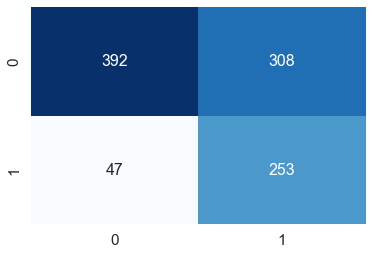

In [1299]:
import seaborn as sn

df_cm = pd.DataFrame(conf_mat, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cbar=False, cmap="Blues") # font size

plt.show()